In [ ]:
!pip install keras_tuner
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a54f2b15c40718ce3c9769bb15ee1ac4e05013a862f42eae0325121643d27d7e
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# sklearn
from sklearn.model_selection       import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline              import Pipeline
from sklearn.linear_model          import LogisticRegression
from sklearn.metrics               import accuracy_score, precision_score, recall_score, f1_score, classification_report

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Keras-Tuner
import keras_tuner as kt

# Hugging Face
from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
import torch

# LIME for explainability
from lime.lime_text import LimeTextExplainer

In [ ]:
# 2. Load & Preprocess

In [ ]:
df = pd.read_csv(

    'Dataset.csv',
    encoding='latin-1',
    names=['target','id','date','flag','user','text']

)

In [ ]:
# 2.2 Map labels
df['sentiment'] = df['target'].map({0: 0, 4: 1})  # 0=neg, 1=pos


In [ ]:
# 2.3 Clean text
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'http\S+|www\.\S+', '', s)      # remove URLs
    s = re.sub(r'@\w+', '', s)                  # remove mentions
    s = re.sub(r'#\w+', '', s)                  # remove hashtags
    s = re.sub(r'[^a-z\s]', '', s)              # keep letters & spaces
    s = re.sub(r'\s+', ' ', s).strip()          # collapse spaces
    return s


In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

In [ ]:
df.clean_text

,clean_text
0,awww thats a bummer you shoulda got david carr...
1,is upset that he cant update his facebook by t...
2,i dived many times for the ball managed to sav...
3,my whole body feels itchy and like its on fire
4,no its not behaving at all im mad why am i her...
...,...
1599995,just woke up having no school is the best feel...
1599996,thewdbcom very cool to hear old walt interviews
1599997,are you ready for your mojo makeover ask me fo...
1599998,happy th birthday to my boo of alll time tupac...


In [ ]:
# 3. EDA
sns.set_style('whitegrid')


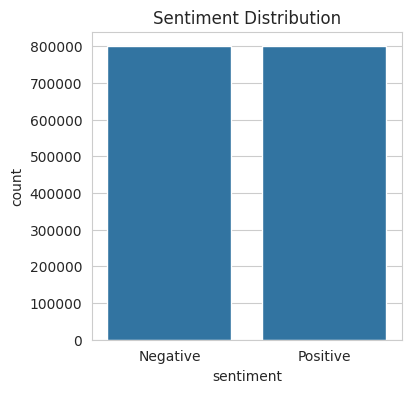

In [ ]:
# 3.1 Class balance
plt.figure(figsize=(4,4))
sns.countplot(x='sentiment', data=df)
plt.xticks([0,1], ['Negative','Positive'])
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
# 3.2 Missing & duplicates
print("Nulls:\n", df.isnull().sum())
print("Duplicate texts:", df.duplicated(subset=['clean_text']).sum())
df = df.drop_duplicates(subset=['clean_text'])

Nulls:
 target        0
id            0
date          0
flag          0
user          0
text          0
sentiment     0
clean_text    0
dtype: int64
Duplicate texts: 82567


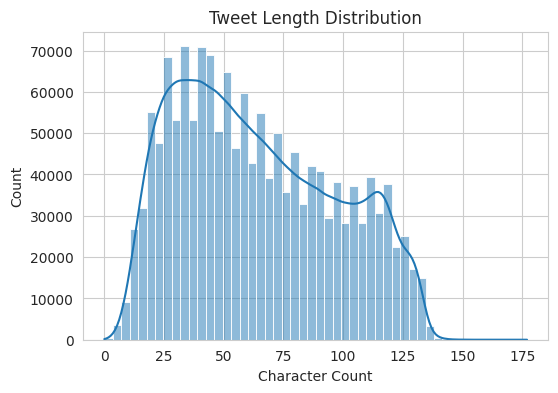

In [ ]:
# 3.3 Tweet length
df['length'] = df['clean_text'].str.len()
plt.figure(figsize=(6,4))
sns.histplot(df['length'], bins=50, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Character Count')
plt.show()

In [ ]:
# 3.4 Top unigrams & bigrams
vect = CountVectorizer(ngram_range=(1,2),
                       max_features=20,
                       stop_words='english')
X_ng = vect.fit_transform(df['clean_text'])
freq = pd.DataFrame({
    'ngram': vect.get_feature_names_out(),
    'count': X_ng.sum(axis=0).A1
}).sort_values('count', ascending=False)
print("Top 10 n-grams:\n", freq.head(10))

Top 10 n-grams:
     ngram   count
6      im  175657
7    just  123403
4    good   83921
1     day   81175
9    like   76574
2    dont   65885
17  today   63576
3   going   62978
11   love   61688
19   work   60142


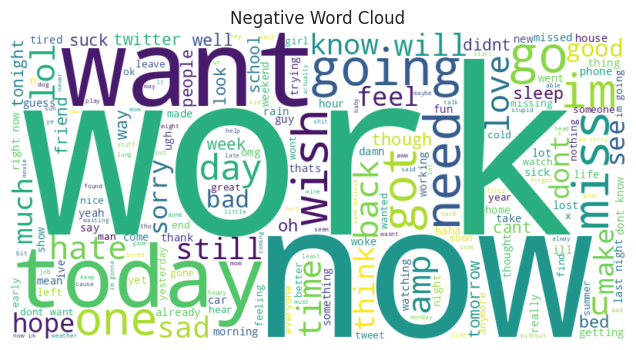

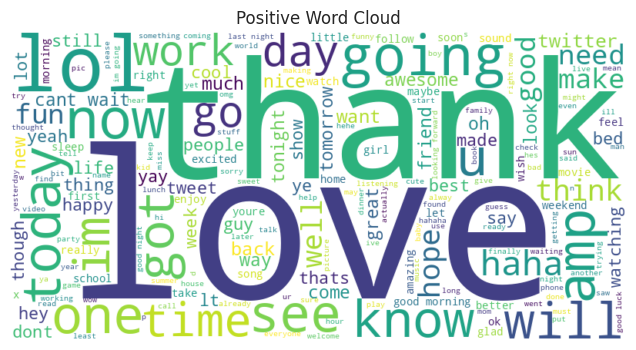

In [ ]:
# 3.5 Word clouds
for label, title in [(0,'Negative'), (1,'Positive')]:
    text = " ".join(df.loc[df['sentiment']==label, 'clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off'); plt.title(f'{title} Word Cloud')
    plt.show()

/usr/local/lib/python3.11/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


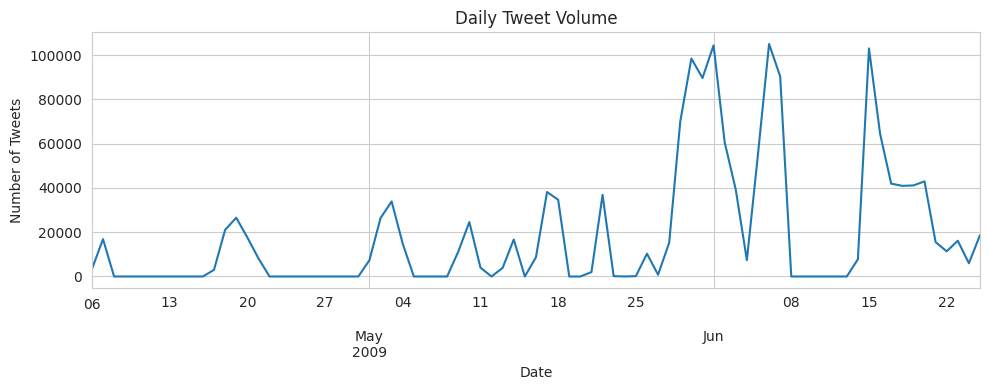

In [ ]:
from dateutil import parser

# 1. Parse using dateutil (handles “PDT”, “GMT”, etc., out of the box)
df['date_parsed'] = df['date'].apply(parser.parse)

# 2. Drop any rows that still failed (should be very few or none)
df = df.dropna(subset=['date_parsed'])

# 3. Resample to daily counts
daily = df.set_index('date_parsed')['sentiment'].resample('D').count()

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
daily.plot()
plt.title('Daily Tweet Volume')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()



In [ ]:
# Split (again, on your cleaned text)
X_train, X_val, y_train, y_val = train_test_split(
    df['clean_text'], df['sentiment'],
    test_size=0.2, random_state=42, stratify=df['sentiment']
)


In [ ]:
# Baseline pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf',   LogisticRegression(max_iter=1000))
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [ ]:
import pickle

# Save Logistic Regression model
with open("logreg_model.pkl", "wb") as f:
    pickle.dump(pipe.named_steps['clf'], f)

# Save TF-IDF vectorizer
with open("logreg_vectorizer.pkl", "wb") as f:
    pickle.dump(pipe.named_steps['tfidf'], f)


In [ ]:
# Baseline pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf',   LogisticRegression(max_iter=1000))
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression(max_iter=1000))])

In [ ]:
# Evaluate
preds = pipe.predict(X_val)
print(classification_report(y_val, preds, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.79      0.75      0.77    153197
    Positive       0.76      0.79      0.77    150290

    accuracy                           0.77    303487
   macro avg       0.77      0.77      0.77    303487
weighted avg       0.77      0.77      0.77    303487



In [ ]:
# 6.1 Tokenize & pad (you can re-use MAX_WORDS, MAX_LEN from before)
MAX_WORDS = 30_000
MAX_LEN   = 100


In [ ]:
!pip install "accelerate>=0.26.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
!pip install --upgrade "transformers[torch]"

In [ ]:
from sklearn.pipeline          import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm               import LinearSVC
from sklearn.model_selection   import GridSearchCV
from sklearn.metrics           import classification_report

# 1. Define the pipeline
svm_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.9)),
    ('svc',   LinearSVC(max_iter=5000))
])




In [ ]:
# 2. (Optional) Hyperparameter tuning
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'svc__C': [0.1, 1, 10]
}



In [ ]:
grid_svm = GridSearchCV(
    svm_pipe, param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
grid_svm.fit(X_train, y_train)



Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9,
                                                        stop_words='english')),
                                       ('svc', LinearSVC(max_iter=5000))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro', verbose=1)

In [ ]:
print("Best SVM Params:", grid_svm.best_params_)
print("CV F1 Score:", grid_svm.best_score_)

# 3. Evaluate on validation set
y_svm_pred = grid_svm.predict(X_val)
print("\nSVM Classification Report:\n",
      classification_report(y_val, y_svm_pred, target_names=['Negative','Positive']))

Best SVM Params: {'svc__C': 0.1, 'tfidf__ngram_range': (1, 2)}
CV F1 Score: 0.7817413262104186

SVM Classification Report:
               precision    recall  f1-score   support

    Negative       0.79      0.78      0.78    153197
    Positive       0.78      0.79      0.78    150290

    accuracy                           0.78    303487
   macro avg       0.78      0.78      0.78    303487
weighted avg       0.78      0.78      0.78    303487



In [ ]:
import pickle

# Save the best SVM model from grid search
with open("svm_model.pkl", "wb") as f:
    pickle.dump(grid_svm.best_estimator_, f)

# Save the TF-IDF vectorizer if pipelined
with open("svm_vectorizer.pkl", "wb") as f:
    pickle.dump(grid_svm.best_estimator_.named_steps['tfidf'], f)


In [ ]:
# Evaluate
preds = pipe.predict(X_val)
print(classification_report(y_val, preds, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.79      0.75      0.77    153197
    Positive       0.76      0.79      0.77    150290

    accuracy                           0.77    303487
   macro avg       0.77      0.77      0.77    303487
weighted avg       0.77      0.77      0.77    303487



In [ ]:
# 6.1 Tokenize & pad (you can re-use MAX_WORDS, MAX_LEN from before)
MAX_WORDS = 30_000
MAX_LEN   = 100


In [ ]:
import torch
from torch.utils.data import TensorDataset

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
from datasets import Dataset


In [ ]:
# 7.1 Prepare HF Dataset
# Use a small pandas slice to match your X_val/y_val split
hf_df = pd.DataFrame({'text': X_train, 'label': y_train})
val_df = pd.DataFrame({'text': X_val,   'label': y_val})


In [ ]:
# Tokenize
tokenizer_bert = BertTokenizerFast.from_pretrained('bert-base-uncased')
def tokenize_fn(batch):
    return tokenizer_bert(batch['text'], padding=True, truncation=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset

# Convert pandas DataFrames to HF Datasets
train_ds = Dataset.from_pandas(hf_df)
val_ds   = Dataset.from_pandas(val_df)

# Tokenize all rows at once (fast + GPU-ready)
train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)

# Format for PyTorch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


Map:   0%|          | 0/1213946 [00:00<?, ? examples/s]

Map:   0%|          | 0/303487 [00:00<?, ? examples/s]

In [ ]:
enc_train = tokenizer_bert(
    X_train.tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

In [ ]:
enc_val = tokenizer_bert(
    X_val.tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

In [ ]:
# Build TensorDatasets
train_ds = TensorDataset(
    enc_train['input_ids'],
    enc_train['attention_mask'],
    torch.tensor(y_train.values)
)
val_ds = TensorDataset(
    enc_val['input_ids'],
    enc_val['attention_mask'],
    torch.tensor(y_val.values)
)


In [ ]:
# DataLoaders
import torch
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(
    train_ds,
    batch_size=512,
    shuffle=True,
    num_workers=12,     # Enables parallel CPU data loading
    pin_memory=True    # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_ds,
    batch_size=512,
    num_workers=12,
    pin_memory=True
)


In [ ]:
import torch
from torch.optim import AdamW
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup



In [ ]:
# 1) Instantiate the model
model_bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 2) Move it to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bert.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# 3) Set up optimizer and scheduler
optimizer = AdamW(model_bert.parameters(), lr=2e-5)

In [ ]:

epochs = 1
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


GPU available: True
Device name: NVIDIA A100-SXM4-40GB


In [ ]:
from tqdm import tqdm
import torch

for epoch in range(1, epochs + 1):
    model_bert.train()
    total_train_loss = 0

    # Progress bar for each batch in the epoch
    loop = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)

    for input_ids, attn_mask, labels in loop:
        # Move data to GPU if available
        input_ids, attn_mask, labels = [t.to(device) for t in (input_ids, attn_mask, labels)]

        # Forward pass
        outputs = model_bert(input_ids=input_ids, attention_mask=attn_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update progress bar with current loss
        loop.set_postfix(batch_loss=loss.item())

    # Calculate and print average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch}/{epochs} — Average Train Loss: {avg_train_loss:.4f}")


Epoch 1/1 — Average Train Loss: 0.3693


In [ ]:
from tqdm import tqdm
from sklearn.metrics import classification_report

# Validation with probs
model_bert.eval()
all_probs, all_labels = [], []

with torch.no_grad():
    loop = tqdm(val_loader, desc=f"Validating", leave=False)
    for input_ids, attn_mask, labels in loop:
        input_ids = input_ids.to(device)
        attn_mask = attn_mask.to(device)

        logits = model_bert(input_ids=input_ids, attention_mask=attn_mask).logits
        probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].cpu()  # probs for class 1

        all_probs.append(probs)
        all_labels.append(labels)

# Concatenate everything
all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)

# Convert probabilities to predicted class labels (0 or 1)
all_preds = (all_probs > 0.5).int()

# Classification report
print(f"\nEpoch {epoch} — Validation Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Positive']))



Epoch 1 — Validation Report:

              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85    153197
    Positive       0.86      0.84      0.85    150290

    accuracy                           0.85    303487
   macro avg       0.85      0.85      0.85    303487
weighted avg       0.85      0.85      0.85    303487



In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_model")


('bert_model/tokenizer_config.json',
 'bert_model/special_tokens_map.json',
 'bert_model/vocab.txt',
 'bert_model/added_tokens.json')

ROC AUC Score: 0.9286


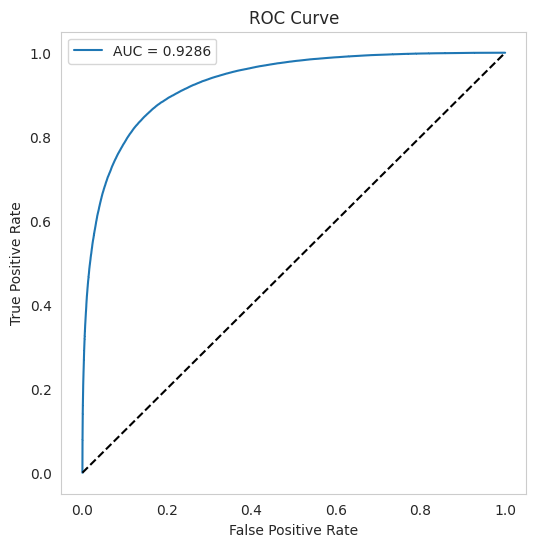

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# AUC Score
auc = roc_auc_score(all_labels, all_probs)
print(f"ROC AUC Score: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


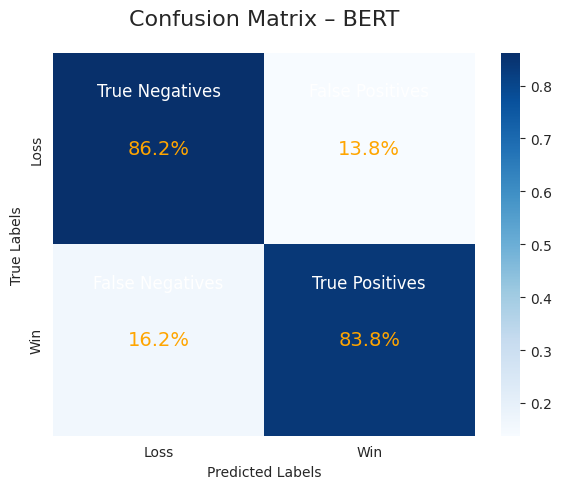

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute normalized confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')  # row-normalized (per class)
labels = ['Loss', 'Win']  # change if needed

# Plot with seaborn
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Blues', cbar=True,
                 xticklabels=labels, yticklabels=labels,
                 annot_kws={"size": 14, "color": "orange"})

# Custom annotations (optional, you can edit text here)
ax.text(0.5, 0.2, 'True Negatives', color='white', ha='center', va='center', fontsize=12)
ax.text(1.5, 0.2, 'False Positives', color='white', ha='center', va='center', fontsize=12)
ax.text(0.5, 1.2, 'False Negatives', color='white', ha='center', va='center', fontsize=12)
ax.text(1.5, 1.2, 'True Positives', color='white', ha='center', va='center', fontsize=12)

# Titles and labels
plt.title("Confusion Matrix – BERT", fontsize=16, pad=20)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()
